Loading data from: /kaggle/input/df3333/df3.csv
Initial rows: 2589
Rows after initial preprocessing & feature calculation: 2568 (removed 21 rows)

--- Creating Feature Sets ---
  Generating lags for: ['Adj Close', 'Log_Return', 'Realized_Volatility_Daily', 'Volume']
Created baseline features (4): ['Adj Close_lag_1', 'Log_Return_lag_1', 'Realized_Volatility_Daily_lag_1', 'Volume_lag_1']
Rows in basic features df after dropna: 2567 (removed 1)
  Generating lags for: ['Adj Close', 'Log_Return', 'Realized_Volatility_Daily', 'Volume']
  Generating rolling features for: ['Adj Close', 'Log_Return', 'Realized_Volatility_Daily', 'Volume']
Created rolling features (36)
Rows in rolling features df after dropna: 2538 (removed 30)

===== Running Forecasts with Step Size: 1 =====

--- Running Multi-Model Adaptive Forecast for 'Adj Close' ---
    Features: 4, Step Size: 1
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Adaptive Steps (Step=1, 4 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 367.29 seconds.

--- Running Multi-Model Adaptive Forecast for 'Adj Close' ---
    Features: 36, Step Size: 1
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=1, 36 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 1394.91 seconds.

===== Running Forecasts with Step Size: 5 =====

--- Running Multi-Model Adaptive Forecast for 'Adj Close' ---
    Features: 4, Step Size: 5
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=5, 4 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 72.44 seconds.

--- Running Multi-Model Adaptive Forecast for 'Adj Close' ---
    Features: 36, Step Size: 5
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=5, 36 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 277.03 seconds.

===== Running Forecasts with Step Size: 10 =====

--- Running Multi-Model Adaptive Forecast for 'Adj Close' ---
    Features: 4, Step Size: 10
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=10, 4 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 36.48 seconds.

--- Running Multi-Model Adaptive Forecast for 'Adj Close' ---
    Features: 36, Step Size: 10
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=10, 36 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 137.98 seconds.

--- Final Evaluation Across Step Sizes ---

--- Evaluating Step Size: 1 ---
  Feature Set: Basic
  Model           | RMSE       | MAE        | Pred Count
  ---------------------------------------------
  LightGBM        | 32.65      | 15.80      | 795       
  XGBoost         | 8.03       | 4.88       | 795       
  RandomForest    | 24.27      | 11.48      | 795       
  Ridge           | 19.13      | 10.07      | 795       
  ---------------------------------------------
  Feature Set: Rolling
  Model           | RMSE       | MAE        | Pred Count
  ---------------------------------------------
  LightGBM        | 24.50      | 9.29       | 795       
  XGBoost         | 2.34       | 1.61       | 795       
  RandomForest    | 23.55      | 10.27      | 795       
  Ridge           | 15.28      | 8.42       | 795       
  ---------------------------------------------

--- Evaluating Step Size: 5 ---
  Feature Set: B

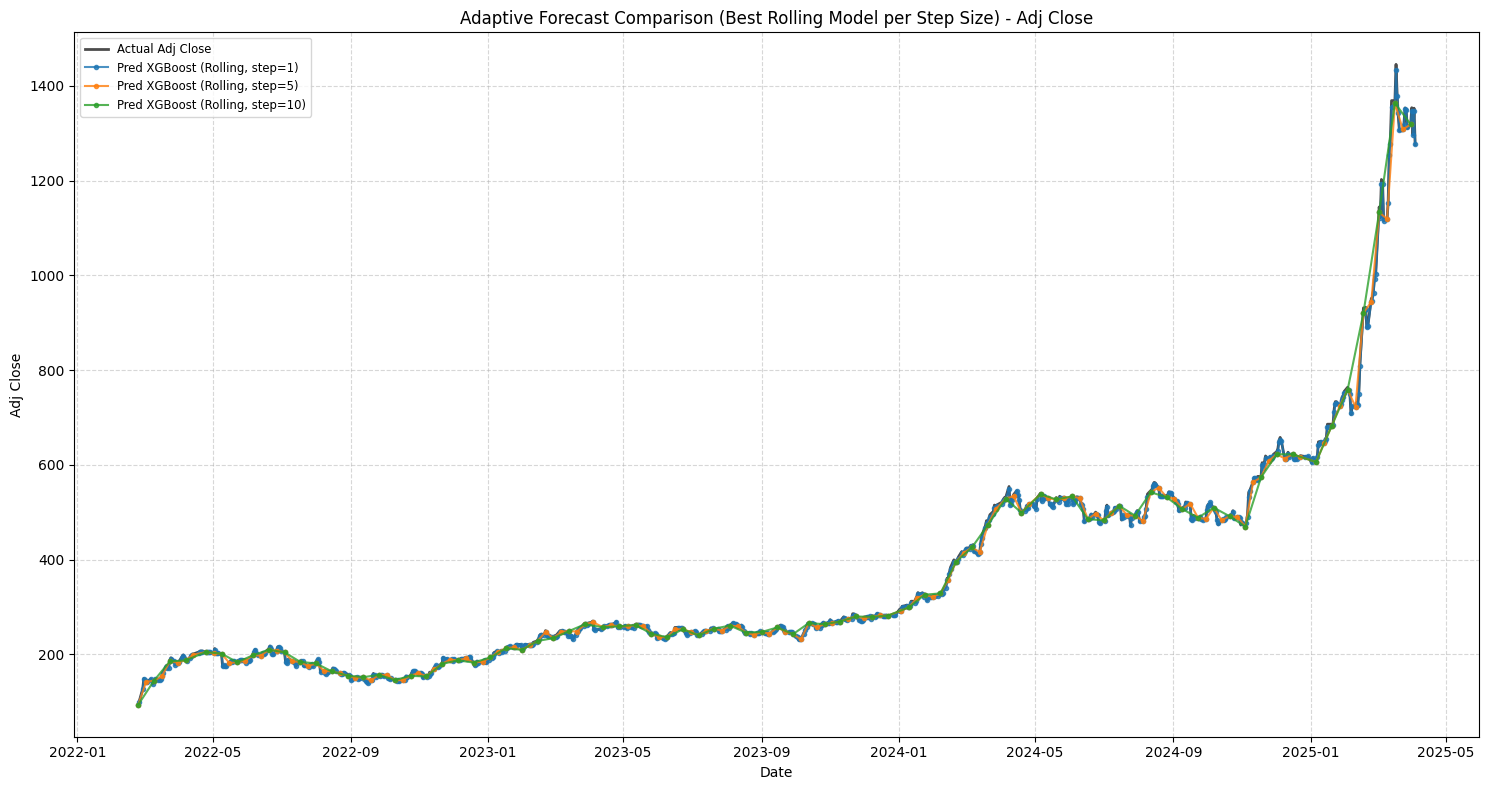

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
import time
from tqdm.notebook import tqdm  

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


def add_lag_features(df, target_col, lags):
    df_out = df.copy()
    all_new_features = []

    cols_to_lag = ["Adj Close", "Volume", "Log_Return"]
    if target_col not in cols_to_lag and target_col in df_out.columns:
        cols_to_lag.append(target_col)
    if "Realized_Volatility_Daily" in df_out.columns:
        cols_to_lag.append("Realized_Volatility_Daily")

    cols_to_lag = sorted(list(set(cols_to_lag)))

    print(f"  Generating lags for: {cols_to_lag}")
    for col in cols_to_lag:
        if col in df_out.columns:
            for lag in lags:
                feature_name = f"{col}_lag_{lag}"
                if feature_name not in df_out.columns:
                    df_out[feature_name] = df_out[col].shift(lag)
                    all_new_features.append(feature_name)
    return df_out, all_new_features


def add_rolling_features(df, windows):
    df_out = df.copy()
    all_new_features = []
    cols_to_roll = ["Adj Close", "Volume", "Log_Return"]
    if "Realized_Volatility_Daily" in df_out.columns:
        cols_to_roll.append("Realized_Volatility_Daily")

    cols_to_roll = sorted(list(set(cols_to_roll)))

    print(f"  Generating rolling features for: {cols_to_roll}")
    for col in cols_to_roll:
        if col in df_out.columns:
            for window in windows:
                mean_feat, std_feat = (
                    f"{col}_roll_mean_{window}",
                    f"{col}_roll_std_{window}",
                )
                if mean_feat not in df_out.columns:
                    df_out[mean_feat] = (
                        df_out[col]
                        .rolling(window=window, min_periods=max(1, window // 2))
                        .mean()
                    )
                    all_new_features.append(mean_feat)
                if std_feat not in df_out.columns:
                    df_out[std_feat] = (
                        df_out[col]
                        .rolling(window=window, min_periods=max(1, window // 2))
                        .std()
                    )
                    all_new_features.append(std_feat)
    return df_out, all_new_features


def run_multi_model_adaptive_forecast(
    df_full_features,
    features,
    target_col,
    models_to_run,
    train_end_date,
    forecast_end_date,
    step_size=1,
):
    print(f"\n--- Running Multi-Model Adaptive Forecast for '{target_col}' ---")
    print(f"    Features: {len(features)}, Step Size: {step_size}")
    all_predictions = {name: {} for name in models_to_run.keys()}
    start_time_total = time.time()

    potential_forecast_dates = df_full_features.loc[
        train_end_date + pd.Timedelta(days=1) : forecast_end_date
    ].index
    potential_forecast_dates = potential_forecast_dates.unique().sort_values()

    if potential_forecast_dates.empty:
        print("No forecast dates found in the specified range.")
        return {name: pd.Series(dtype=float) for name in models_to_run.keys()}

    print(
        f"Forecasting from {potential_forecast_dates.min().strftime('%Y-%m-%d')} to {potential_forecast_dates.max().strftime('%Y-%m-%d')}"
    )
    print(f"Total potential forecast steps: {len(potential_forecast_dates)}")

    for current_idx, current_date in enumerate(
        tqdm(
            potential_forecast_dates,
            desc=f"Adaptive Steps (Step={step_size}, {len(features)} feats)",
        )
    ):
        if current_idx % step_size != 0:
            continue  

        try:
            current_date_loc_in_full = df_full_features.index.get_loc(current_date)
            if current_date_loc_in_full == 0:
                print(
                    f"Warning: current_date {current_date.strftime('%Y-%m-%d')} is the first date. Skipping."
                )
                continue
            train_end_idx_date = df_full_features.index[current_date_loc_in_full - 1]
        except (KeyError, IndexError):
            print(
                f"Warning: Could not find previous date for {current_date.strftime('%Y-%m-%d')} in df_full_features. Skipping step."
            )
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        current_train_data = df_full_features.loc[
            df_full_features.index <= train_end_idx_date
        ].copy()


        training_features = current_train_data[features]
        training_target = (
            df_full_features[target_col].shift(-1).loc[training_features.index]
        )

        combined_train = pd.concat(
            [training_features, training_target.rename("target_for_train")], axis=1
        )
        combined_train.dropna(inplace=True)

        if combined_train.empty:
            print(
                f"Warning: No valid training data available for step ending {train_end_idx_date.strftime('%Y-%m-%d')}. Setting predictions to NaN for {current_date.strftime('%Y-%m-%d')}."
            )
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        X_train = combined_train[features]
        y_train = combined_train["target_for_train"]
        X_train.columns = X_train.columns.astype(str)

        try:
            features_for_prediction = df_full_features.loc[[train_end_idx_date]][
                features
            ]
            features_for_prediction.columns = features_for_prediction.columns.astype(
                str
            )
        except KeyError:
            print(
                f"Warning: Could not retrieve features for prediction date {train_end_idx_date.strftime('%Y-%m-%d')}. Setting predictions to NaN for {current_date.strftime('%Y-%m-%d')}."
            )
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        if features_for_prediction.isnull().any().any():
            print(
                f"Warning: Features for prediction on {train_end_idx_date.strftime('%Y-%m-%d')} contain NaNs. Setting predictions to NaN for {current_date.strftime('%Y-%m-%d')}."
            )
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        needs_scaling = ["Ridge"]  
        scaler = None
        X_train_scaled_np = None
        X_pred_scaled_np = None
        if any(m in needs_scaling for m in models_to_run):
            scaler = StandardScaler()
            X_train_scaled_np = scaler.fit_transform(X_train.values)
            X_pred_scaled_np = scaler.transform(features_for_prediction.values)

        for model_name, model_config in models_to_run.items():
            model = model_config["model"](**model_config.get("params", {}))

            try:
                if model_name in needs_scaling:
                    if X_train_scaled_np is None or X_pred_scaled_np is None:
                        raise ValueError(
                            "Scaled data not available for scaling-required model."
                        )
                    model.fit(X_train_scaled_np, y_train)
                    pred = model.predict(X_pred_scaled_np)[0]
                else:
                    model.fit(X_train.values, y_train)
                    pred = model.predict(features_for_prediction.values)[0]
                all_predictions[model_name][current_date] = pred
            except Exception as e:
                print(
                    f"Error during training/prediction for {model_name} on {current_date.strftime('%Y-%m-%d')}: {e}"
                )
                all_predictions[model_name][current_date] = np.nan


    print(
        f"Finished multi-model adaptive forecast. Total time: {time.time() - start_time_total:.2f} seconds."
    )

    final_predictions = {
        name: pd.Series(preds).sort_index() for name, preds in all_predictions.items()
    }
    return final_predictions


if __name__ == "__main__":
    DATA_FILE_PATH = "/kaggle/input/df3333/df3.csv"
    TARGET_VARIABLE = (
        "Adj Close" 
    )
    TRAIN_END_DATE = pd.to_datetime("2022-02-23")
    FORECAST_END_DATE = pd.to_datetime("2025-04-04")  

    MODELS_TO_RUN = {
        "LightGBM": {
            "model": lgb.LGBMRegressor,
            "params": {
                "objective": "regression",
                "metric": "rmse",
                "n_estimators": 200,
                "learning_rate": 0.05,
                "feature_fraction": 0.8,
                "bagging_fraction": 0.8,
                "bagging_freq": 1,
                "lambda_l1": 0.1,
                "lambda_l2": 0.1,
                "num_leaves": 15,
                "verbose": -1,
                "n_jobs": -1,
                "seed": 42,
                "boosting_type": "gbdt",
            },
        },
        "XGBoost": {
            "model": xgb.XGBRegressor,
            "params": {
                "objective": "reg:squarederror",
                "n_estimators": 100,
                "learning_rate": 0.1,
                "max_depth": 5,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "random_state": 42,
                "n_jobs": -1,
                "tree_method": "hist",
            },
        },
        "RandomForest": {
            "model": RandomForestRegressor,
            "params": {
                "n_estimators": 100,
                "max_depth": 10,
                "min_samples_leaf": 5,
                "random_state": 42,
                "n_jobs": -1,
            },
        },
        "Ridge": {"model": Ridge, "params": {"alpha": 1.0, "random_state": 42}},
    }

    print(f"Loading data from: {DATA_FILE_PATH}")
    df = pd.read_csv(DATA_FILE_PATH, parse_dates=["Date"], index_col="Date")
    df.sort_index(inplace=True)
    print(f"Initial rows: {len(df)}")
    required_cols = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
    if not all(col in df.columns for col in required_cols):
        if "Adj Close" not in df.columns and "Close" in df.columns:
            print("Warning: 'Adj Close' not found, using 'Close' instead.")
            df["Adj Close"] = df["Close"]  
            required_cols.remove("Adj Close")
            if not all(col in df.columns for col in required_cols):
                raise ValueError(
                    f"Missing required columns even after using 'Close': {required_cols}"
                )
        else:
            raise ValueError(f"Missing required columns: {required_cols}")

    df["Adj Close"] = (
        df["Adj Close"].replace(0, np.nan).ffill()
    )  
    df["Log_Return"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))

    window = 21 
    df["Realized_Volatility_Daily"] = df["Log_Return"].rolling(window=window).std()

    initial_rows = len(df)
    df.dropna(subset=["Log_Return", "Realized_Volatility_Daily"], inplace=True)
    print(
        f"Rows after initial preprocessing & feature calculation: {len(df)} (removed {initial_rows - len(df)} rows)"
    )

    print("\n--- Creating Feature Sets ---")

    df_features_basic = df.copy()
    df_features_basic, BASE_FEATURES_list = add_lag_features(
        df_features_basic, TARGET_VARIABLE, lags=[1]
    )
    BASE_FEATURES = list(BASE_FEATURES_list)
    print(f"Created baseline features ({len(BASE_FEATURES)}): {BASE_FEATURES}")
    initial_rows_basic = len(df_features_basic)
    df_features_basic.dropna(subset=BASE_FEATURES, inplace=True)
    print(
        f"Rows in basic features df after dropna: {len(df_features_basic)} (removed {initial_rows_basic - len(df_features_basic)})"
    )

    df_features_rolling = df.copy()
    df_features_rolling, base_lags = add_lag_features(
        df_features_rolling, TARGET_VARIABLE, lags=[1]
    )
    df_features_rolling, rolling_features_list = add_rolling_features(
        df_features_rolling, windows=[5, 10, 21, 63]
    )
    ROLLING_FEATURES = sorted(list(set(base_lags + rolling_features_list)))
    print(
        f"Created rolling features ({len(ROLLING_FEATURES)})"
    )  
    initial_rows_rolling = len(df_features_rolling)
    df_features_rolling.dropna(subset=ROLLING_FEATURES, inplace=True)
    print(
        f"Rows in rolling features df after dropna: {len(df_features_rolling)} (removed {initial_rows_rolling - len(df_features_rolling)})"
    )

    step_sizes_to_run = [1, 5, 10]  
    all_results_by_step = {}

    for step in step_sizes_to_run:
        print(f"\n===== Running Forecasts with Step Size: {step} =====")
        all_preds_step = {}

        all_preds_step["Basic"] = run_multi_model_adaptive_forecast(
            df_features_basic,
            BASE_FEATURES,
            TARGET_VARIABLE,
            MODELS_TO_RUN,
            TRAIN_END_DATE,
            FORECAST_END_DATE,
            step_size=step,  
        )

        all_preds_step["Rolling"] = run_multi_model_adaptive_forecast(
            df_features_rolling,
            ROLLING_FEATURES,
            TARGET_VARIABLE,
            MODELS_TO_RUN,
            TRAIN_END_DATE,
            FORECAST_END_DATE,
            step_size=step,  
        )
        all_results_by_step[step] = all_preds_step

    print("\n--- Final Evaluation Across Step Sizes ---")

    evaluation_metrics = {}  

    for step, results_step in all_results_by_step.items():
        print(f"\n--- Evaluating Step Size: {step} ---")
        evaluation_metrics[step] = {}
        for feature_set, model_preds_dict in results_step.items():
            evaluation_metrics[step][feature_set] = {}
            print(f"  Feature Set: {feature_set}")
            print(f"  {'Model':<15} | {'RMSE':<10} | {'MAE':<10} | {'Pred Count':<10}")
            print("  " + "-" * 45)
            for model_name, preds in model_preds_dict.items():
                if preds.empty:
                    print(f"  {model_name:<15} | {'NaN':<10} | {'NaN':<10} | {0:<10}")
                    evaluation_metrics[step][feature_set][model_name] = {
                        "RMSE": np.nan,
                        "MAE": np.nan,
                        "Count": 0,
                    }
                    continue

                actuals = df.loc[preds.index, TARGET_VARIABLE]
                comparison_df = pd.DataFrame(
                    {"Actual": actuals, "Predicted": preds}
                ).dropna()

                if not comparison_df.empty:
                    rmse = mean_squared_error(
                        comparison_df["Actual"],
                        comparison_df["Predicted"],
                        squared=False,
                    )
                    mae = mean_absolute_error(
                        comparison_df["Actual"], comparison_df["Predicted"]
                    )
                    count = len(comparison_df)
                    print(
                        f"  {model_name:<15} | {rmse:<10.2f} | {mae:<10.2f} | {count:<10}"
                    )
                    evaluation_metrics[step][feature_set][model_name] = {
                        "RMSE": rmse,
                        "MAE": mae,
                        "Count": count,
                    }
                else:
                    print(f"  {model_name:<15} | {'NaN':<10} | {'NaN':<10} | {0:<10}")
                    evaluation_metrics[step][feature_set][model_name] = {
                        "RMSE": np.nan,
                        "MAE": np.nan,
                        "Count": 0,
                    }
            print("  " + "-" * 45)

    plt.figure(figsize=(15, 8))
    actuals_plot = df.loc[
        TRAIN_END_DATE + pd.Timedelta(days=1) : FORECAST_END_DATE, TARGET_VARIABLE
    ]
    plt.plot(
        actuals_plot.index,
        actuals_plot,
        label=f"Actual {TARGET_VARIABLE}",
        color="black",
        linewidth=2,
        alpha=0.7,
    )
    colors = plt.cm.viridis(
        np.linspace(0, 1, len(step_sizes_to_run) * len(MODELS_TO_RUN))
    )
    color_idx = 0

    best_models_rolling = {}
    for step in step_sizes_to_run:
        rolling_metrics = evaluation_metrics.get(step, {}).get("Rolling", {})
        if rolling_metrics:
            valid_models = {
                m: metrics
                for m, metrics in rolling_metrics.items()
                if pd.notna(metrics["RMSE"])
            }
            if valid_models:
                best_model_name = min(
                    valid_models, key=lambda k: valid_models[k]["RMSE"]
                )
                best_models_rolling[step] = best_model_name
                print(
                    f"Best Rolling model for step={step}: {best_model_name} (RMSE: {valid_models[best_model_name]['RMSE']:.2f})"
                )

    for step, model_name in best_models_rolling.items():
        preds = all_results_by_step[step]["Rolling"][model_name]
        if not preds.empty:
            plt.plot(
                preds.index,
                preds,
                marker="o",
                linestyle="-",
                markersize=3,
                label=f"Pred {model_name} (Rolling, step={step})",
                alpha=0.8,
            )  
            color_idx += 1

    plt.title(
        f"Adaptive Forecast Comparison (Best Rolling Model per Step Size) - {TARGET_VARIABLE}"
    )
    plt.xlabel("Date")
    plt.ylabel(f"{TARGET_VARIABLE}")
    plt.legend(loc="upper left", fontsize="small")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"adaptive_forecast_comparison_steps_{TARGET_VARIABLE}.png")
    plt.show()


Loading data from: /kaggle/input/df3333/df3.csv
Initial rows: 2589
Scaled 'Realized_Volatility_Daily' to percentage points.
Rows after initial preprocessing & feature calculation: 2568 (removed 21 rows)

--- Creating Feature Sets ---
Created baseline features (4): ['Adj Close_lag_1', 'Log_Return_lag_1', 'Realized_Volatility_Daily_lag_1', 'Volume_lag_1']
Rows in basic features df after dropna: 2567 (removed 1)
Created rolling features (36)
Rows in rolling features df after dropna: 2538 (removed 30)

===== Running Forecasts with Step Size: 1 =====

--- Running Multi-Model Adaptive Forecast for 'Realized_Volatility_Daily' ---
    Features: 4, Step Size: 1
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Adaptive Steps (Step=1, 4 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 366.13 seconds.

--- Running Multi-Model Adaptive Forecast for 'Realized_Volatility_Daily' ---
    Features: 36, Step Size: 1
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=1, 36 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 1401.63 seconds.

===== Running Forecasts with Step Size: 5 =====

--- Running Multi-Model Adaptive Forecast for 'Realized_Volatility_Daily' ---
    Features: 4, Step Size: 5
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=5, 4 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 72.02 seconds.

--- Running Multi-Model Adaptive Forecast for 'Realized_Volatility_Daily' ---
    Features: 36, Step Size: 5
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=5, 36 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 279.16 seconds.

===== Running Forecasts with Step Size: 10 =====

--- Running Multi-Model Adaptive Forecast for 'Realized_Volatility_Daily' ---
    Features: 4, Step Size: 10
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=10, 4 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 36.12 seconds.

--- Running Multi-Model Adaptive Forecast for 'Realized_Volatility_Daily' ---
    Features: 36, Step Size: 10
Forecasting from 2022-02-24 to 2025-04-04
Total potential forecast steps: 795


Adaptive Steps (Step=10, 36 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 141.27 seconds.

--- Final Evaluation Across Step Sizes ---

--- Evaluating Step Size: 1 ---
  Feature Set: Basic
  Model           | RMSE (%)   | MAE (%)    | QLIKE      | Pred Count
  --------------------------------------------------------------
  LightGBM        | 4.36       | 2.56       | 0.0203     | 795       
  XGBoost         | 2.24       | 1.59       | 0.0081     | 795       
  RandomForest    | 4.46       | 2.40       | 0.0214     | 795       
  Ridge           | 5.34       | 2.82       | 0.0343     | 795       
  --------------------------------------------------------------
  Feature Set: Rolling
  Model           | RMSE (%)   | MAE (%)    | QLIKE      | Pred Count
  --------------------------------------------------------------
  LightGBM        | 2.28       | 1.27       | 0.0058     | 795       
  XGBoost         | 1.15       | 0.80       | 0.0023     | 795       
  RandomForest    | 2.81       | 1.33       | 0.0085    

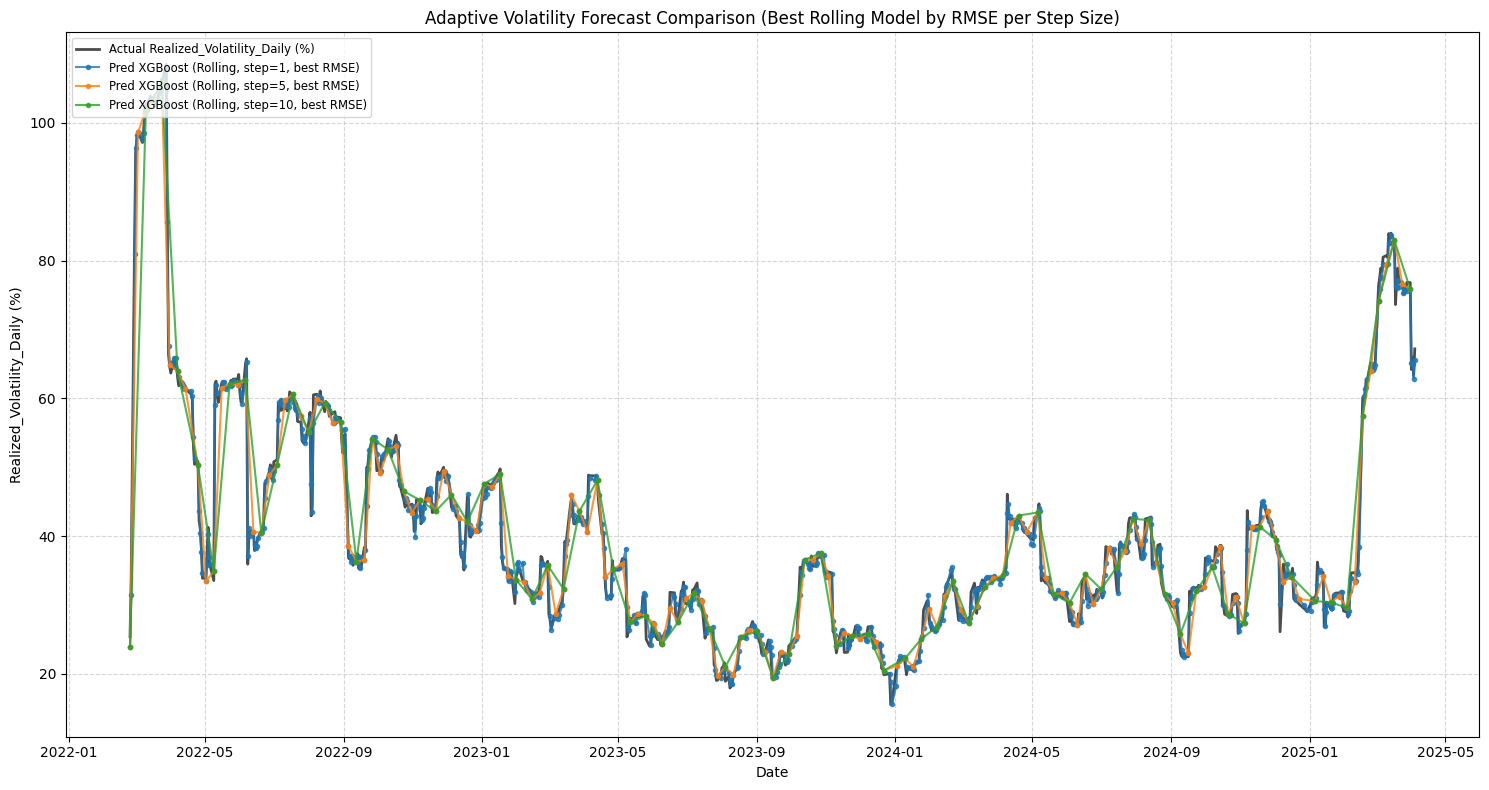

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
import time
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



def add_lag_features(df, target_col, lags):
    df_out = df.copy()
    all_new_features = []
    cols_to_lag = ["Adj Close", "Volume", "Log_Return"]
    if target_col not in cols_to_lag and target_col in df_out.columns:
        cols_to_lag.append(target_col)
    if "Realized_Volatility_Daily" in df_out.columns:
        if target_col != "Realized_Volatility_Daily":
            cols_to_lag.append("Realized_Volatility_Daily")
    cols_to_lag = sorted(list(set(cols_to_lag)))
    for col in cols_to_lag:
        if col in df_out.columns:
            for lag in lags:
                feature_name = f"{col}_lag_{lag}"
                if feature_name not in df_out.columns:
                    df_out[feature_name] = df_out[col].shift(lag)
                    all_new_features.append(feature_name)
    return df_out, all_new_features


def add_rolling_features(df, windows):
    df_out = df.copy()
    all_new_features = []
    cols_to_roll = ["Adj Close", "Volume", "Log_Return"]
    if "Realized_Volatility_Daily" in df_out.columns:
        if "Realized_Volatility_Daily" not in cols_to_roll:
            cols_to_roll.append("Realized_Volatility_Daily")
    cols_to_roll = sorted(list(set(cols_to_roll)))
    for col in cols_to_roll:
        if col in df_out.columns:
            for window in windows:
                mean_feat, std_feat = (
                    f"{col}_roll_mean_{window}",
                    f"{col}_roll_std_{window}",
                )
                if mean_feat not in df_out.columns:
                    df_out[mean_feat] = (
                        df_out[col]
                        .rolling(window=window, min_periods=max(1, window // 2))
                        .mean()
                    )
                    all_new_features.append(mean_feat)
                if std_feat not in df_out.columns:
                    df_out[std_feat] = (
                        df_out[col]
                        .rolling(window=window, min_periods=max(1, window // 2))
                        .std()
                    )
                    all_new_features.append(std_feat)
    return df_out, all_new_features



def run_multi_model_adaptive_forecast(
    df_full_features,
    features,
    target_col,
    models_to_run,
    train_end_date,
    forecast_end_date,
    step_size=1,
):
    print(f"\n--- Running Multi-Model Adaptive Forecast for '{target_col}' ---")
    print(f"    Features: {len(features)}, Step Size: {step_size}")
    all_predictions = {name: {} for name in models_to_run.keys()}
    start_time_total = time.time()
    potential_forecast_dates = df_full_features.loc[
        train_end_date + pd.Timedelta(days=1) : forecast_end_date
    ].index
    potential_forecast_dates = potential_forecast_dates.unique().sort_values()
    if potential_forecast_dates.empty:
        return {name: pd.Series(dtype=float) for name in models_to_run.keys()}
    print(
        f"Forecasting from {potential_forecast_dates.min().strftime('%Y-%m-%d')} to {potential_forecast_dates.max().strftime('%Y-%m-%d')}"
    )
    print(f"Total potential forecast steps: {len(potential_forecast_dates)}")
    for current_idx, current_date in enumerate(
        tqdm(
            potential_forecast_dates,
            desc=f"Adaptive Steps (Step={step_size}, {len(features)} feats)",
        )
    ):
        if current_idx % step_size != 0:
            continue
        try:
            current_date_loc_in_full = df_full_features.index.get_loc(current_date)
            if current_date_loc_in_full == 0:
                continue
            train_end_idx_date = df_full_features.index[current_date_loc_in_full - 1]
        except (KeyError, IndexError):
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue
        current_train_data = df_full_features.loc[
            df_full_features.index <= train_end_idx_date
        ].copy()
        training_features = current_train_data[features]
        training_target = (
            df_full_features[target_col].shift(-1).loc[training_features.index]
        )
        combined_train = pd.concat(
            [training_features, training_target.rename("target_for_train")], axis=1
        )
        combined_train.dropna(inplace=True)
        if combined_train.empty:
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue
        X_train = combined_train[features]
        y_train = combined_train["target_for_train"]
        X_train.columns = X_train.columns.astype(str)
        try:
            features_for_prediction = df_full_features.loc[[train_end_idx_date]][
                features
            ]
            features_for_prediction.columns = features_for_prediction.columns.astype(
                str
            )
        except KeyError:
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue
        if features_for_prediction.isnull().any().any():
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue
        needs_scaling = ["Ridge"]
        scaler = None
        X_train_scaled_np = None
        X_pred_scaled_np = None
        if any(m in needs_scaling for m in models_to_run):
            scaler = StandardScaler()
            X_train_scaled_np = scaler.fit_transform(X_train.values)
            X_pred_scaled_np = scaler.transform(features_for_prediction.values)
        for model_name, model_config in models_to_run.items():
            model = model_config["model"](**model_config.get("params", {}))
            try:
                if model_name in needs_scaling:
                    if X_train_scaled_np is None or X_pred_scaled_np is None:
                        raise ValueError("Scaled data not available")
                    model.fit(X_train_scaled_np, y_train)
                    pred = model.predict(X_pred_scaled_np)[0]
                else:
                    model.fit(X_train.values, y_train)
                    pred = model.predict(features_for_prediction.values)[0]
                all_predictions[model_name][current_date] = pred
            except Exception as e:
                print(
                    f"Error during training/prediction for {model_name} on {current_date.strftime('%Y-%m-%d')}: {e}"
                )
                all_predictions[model_name][current_date] = np.nan
    print(
        f"Finished multi-model adaptive forecast. Total time: {time.time() - start_time_total:.2f} seconds."
    )
    final_predictions = {
        name: pd.Series(preds).sort_index() for name, preds in all_predictions.items()
    }
    return final_predictions


def calculate_qlike(actual, predicted):
    epsilon = 1e-10
    actual_sq = np.maximum(actual**2, epsilon)
    predicted_sq = np.maximum(predicted**2, epsilon)


    loss = actual_sq / predicted_sq - np.log(actual_sq / predicted_sq) - 1
    return np.mean(loss)


if __name__ == "__main__":
    DATA_FILE_PATH = "/kaggle/input/df3333/df3.csv"
    TARGET_VARIABLE = "Realized_Volatility_Daily"  
    TRAIN_END_DATE = pd.to_datetime("2022-02-23")
    FORECAST_END_DATE = pd.to_datetime("2025-04-04")

    MODELS_TO_RUN = {
        "LightGBM": {
            "model": lgb.LGBMRegressor,
            "params": {
                "objective": "regression",
                "metric": "rmse",
                "n_estimators": 200,
                "learning_rate": 0.05,
                "feature_fraction": 0.8,
                "bagging_fraction": 0.8,
                "bagging_freq": 1,
                "lambda_l1": 0.1,
                "lambda_l2": 0.1,
                "num_leaves": 15,
                "verbose": -1,
                "n_jobs": -1,
                "seed": 42,
                "boosting_type": "gbdt",
            },
        },
        "XGBoost": {
            "model": xgb.XGBRegressor,
            "params": {
                "objective": "reg:squarederror",
                "n_estimators": 100,
                "learning_rate": 0.1,
                "max_depth": 5,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "random_state": 42,
                "n_jobs": -1,
                "tree_method": "hist",
            },
        },
        "RandomForest": {
            "model": RandomForestRegressor,
            "params": {
                "n_estimators": 100,
                "max_depth": 10,
                "min_samples_leaf": 5,
                "random_state": 42,
                "n_jobs": -1,
            },
        },
        "Ridge": {"model": Ridge, "params": {"alpha": 1.0, "random_state": 42}},
    }

    print(f"Loading data from: {DATA_FILE_PATH}")
    df = pd.read_csv(DATA_FILE_PATH, parse_dates=["Date"], index_col="Date")
    df.sort_index(inplace=True)
    print(f"Initial rows: {len(df)}")
    required_cols = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
    if not all(col in df.columns for col in required_cols):
        if "Adj Close" not in df.columns and "Close" in df.columns:
            df["Adj Close"] = df["Close"]
            required_cols.remove("Adj Close")
            if not all(col in df.columns for col in required_cols):
                raise ValueError(f"Missing required columns: {required_cols}")
        else:
            raise ValueError(f"Missing required columns: {required_cols}")
    df["Adj Close"] = df["Adj Close"].replace(0, np.nan).ffill()
    df["Log_Return"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
    window = 21
    df["Realized_Volatility_Daily_Raw"] = df["Log_Return"].rolling(window=window).std()
    annualization_factor = 260
    df[TARGET_VARIABLE] = df["Realized_Volatility_Daily_Raw"] * 100 * np.sqrt(annualization_factor)
    print(f"Scaled '{TARGET_VARIABLE}' to percentage points.")
    initial_rows = len(df)
    df.dropna(subset=["Log_Return", TARGET_VARIABLE], inplace=True)
    print(
        f"Rows after initial preprocessing & feature calculation: {len(df)} (removed {initial_rows - len(df)} rows)"
    )

    print("\n--- Creating Feature Sets ---")
    df_features_basic = df.copy()
    df_features_basic, BASE_FEATURES_list = add_lag_features(
        df_features_basic, TARGET_VARIABLE, lags=[1]
    )
    BASE_FEATURES = list(BASE_FEATURES_list)
    print(f"Created baseline features ({len(BASE_FEATURES)}): {BASE_FEATURES}")
    initial_rows_basic = len(df_features_basic)
    df_features_basic.dropna(subset=BASE_FEATURES, inplace=True)
    print(
        f"Rows in basic features df after dropna: {len(df_features_basic)} (removed {initial_rows_basic - len(df_features_basic)})"
    )

    df_features_rolling = df.copy()
    df_features_rolling, base_lags = add_lag_features(
        df_features_rolling, TARGET_VARIABLE, lags=[1]
    )
    df_features_rolling, rolling_features_list = add_rolling_features(
        df_features_rolling, windows=[5, 10, 21, 63]
    )
    ROLLING_FEATURES = sorted(list(set(base_lags + rolling_features_list)))
    print(f"Created rolling features ({len(ROLLING_FEATURES)})")
    initial_rows_rolling = len(df_features_rolling)
    df_features_rolling.dropna(subset=ROLLING_FEATURES, inplace=True)
    print(
        f"Rows in rolling features df after dropna: {len(df_features_rolling)} (removed {initial_rows_rolling - len(df_features_rolling)})"
    )

    step_sizes_to_run = [1, 5, 10]
    all_results_by_step = {}
    for step in step_sizes_to_run:
        print(f"\n===== Running Forecasts with Step Size: {step} =====")
        all_preds_step = {}
        all_preds_step["Basic"] = run_multi_model_adaptive_forecast(
            df_features_basic,
            BASE_FEATURES,
            TARGET_VARIABLE,
            MODELS_TO_RUN,
            TRAIN_END_DATE,
            FORECAST_END_DATE,
            step_size=step,
        )
        all_preds_step["Rolling"] = run_multi_model_adaptive_forecast(
            df_features_rolling,
            ROLLING_FEATURES,
            TARGET_VARIABLE,
            MODELS_TO_RUN,
            TRAIN_END_DATE,
            FORECAST_END_DATE,
            step_size=step,
        )
        all_results_by_step[step] = all_preds_step

    print("\n--- Final Evaluation Across Step Sizes ---")
    evaluation_metrics = {}

    for step, results_step in all_results_by_step.items():
        print(f"\n--- Evaluating Step Size: {step} ---")
        evaluation_metrics[step] = {}
        for feature_set, model_preds_dict in results_step.items():
            evaluation_metrics[step][feature_set] = {}
            print(f"  Feature Set: {feature_set}")
            print(
                f"  {'Model':<15} | {'RMSE (%)':<10} | {'MAE (%)':<10} | {'QLIKE':<10} | {'Pred Count':<10}"
            )
            print("  " + "-" * 62)  
            for model_name, preds in model_preds_dict.items():
                rmse, mae, qlike, count = np.nan, np.nan, np.nan, 0
                if not preds.empty:
                    actuals = df.loc[preds.index, TARGET_VARIABLE]
                    comparison_df = pd.DataFrame(
                        {"Actual": actuals, "Predicted": preds}
                    ).dropna()

                    if not comparison_df.empty:
                        actual_vals = comparison_df["Actual"].values
                        predicted_vals = comparison_df["Predicted"].values

                        rmse = mean_squared_error(
                            actual_vals, predicted_vals, squared=False
                        )
                        mae = mean_absolute_error(actual_vals, predicted_vals)
                        count = len(comparison_df)

                        qlike = calculate_qlike(actual_vals, predicted_vals)

                evaluation_metrics[step][feature_set][model_name] = {
                    "RMSE": rmse,
                    "MAE": mae,
                    "QLIKE": qlike,
                    "Count": count,
                }
                print(
                    f"  {model_name:<15} | {rmse:<10.2f} | {mae:<10.2f} | {qlike:<10.4f} | {count:<10}"
                )

            print("  " + "-" * 62)


    plt.figure(figsize=(15, 8))
    actuals_plot = df.loc[
        TRAIN_END_DATE + pd.Timedelta(days=1) : FORECAST_END_DATE, TARGET_VARIABLE
    ]
    plt.plot(
        actuals_plot.index,
        actuals_plot,
        label=f"Actual {TARGET_VARIABLE} (%)",
        color="black",
        linewidth=2,
        alpha=0.7,
    )

    colors = plt.cm.viridis(
        np.linspace(0, 1, len(step_sizes_to_run) * len(MODELS_TO_RUN))
    )
    color_idx = 0

    best_models_rolling_rmse = {}
    best_models_rolling_qlike = {} 

    print("\n--- Best Rolling Models per Step Size ---")
    for step in step_sizes_to_run:
        rolling_metrics = evaluation_metrics.get(step, {}).get("Rolling", {})
        if rolling_metrics:
            valid_models_rmse = {
                m: metrics
                for m, metrics in rolling_metrics.items()
                if pd.notna(metrics["RMSE"])
            }
            valid_models_qlike = {
                m: metrics
                for m, metrics in rolling_metrics.items()
                if pd.notna(metrics["QLIKE"])
            }  

            if valid_models_rmse:
                best_model_name_rmse = min(
                    valid_models_rmse, key=lambda k: valid_models_rmse[k]["RMSE"]
                )
                best_models_rolling_rmse[step] = best_model_name_rmse
                print(
                    f"Step={step} Best by RMSE: {best_model_name_rmse} (RMSE: {valid_models_rmse[best_model_name_rmse]['RMSE']:.2f} %, QLIKE: {valid_models_rmse[best_model_name_rmse]['QLIKE']:.4f})"
                )

            if valid_models_qlike:
                best_model_name_qlike = min(
                    valid_models_qlike, key=lambda k: valid_models_qlike[k]["QLIKE"]
                )
                best_models_rolling_qlike[step] = best_model_name_qlike
                print(
                    f"Step={step} Best by QLIKE: {best_model_name_qlike} (RMSE: {valid_models_qlike[best_model_name_qlike]['RMSE']:.2f} %, QLIKE: {valid_models_qlike[best_model_name_qlike]['QLIKE']:.4f})"
                )

    print("\nPlotting best models based on RMSE...")
    for (
        step,
        model_name,
    ) in best_models_rolling_rmse.items(): 
        preds = all_results_by_step[step]["Rolling"][model_name]
        if not preds.empty:
            plt.plot(
                preds.index,
                preds,
                marker="o",
                linestyle="-",
                markersize=3,
                label=f"Pred {model_name} (Rolling, step={step}, best RMSE)",
                alpha=0.8,
            )  
            color_idx += 1

    plt.title(
        f"Adaptive Volatility Forecast Comparison (Best Rolling Model by RMSE per Step Size)"
    )  
    plt.xlabel("Date")
    plt.ylabel(f"{TARGET_VARIABLE} (%)")
    plt.legend(loc="upper left", fontsize="small")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(
        f"adaptive_forecast_comparison_steps_{TARGET_VARIABLE}_bestRMSE.png"
    )  
    plt.show()
